In [ ]:
# dataloader testing

import numpy as np
import glob
import os
from PIL import Image

path = "/home/ICT2000/chenh/Haiwei/Datasets/OWT/Catalina_Full/OutputImageSegmentation_Catalina/Images" 

files = glob.glob(os.path.join(path,'*.JPG'))
files_seg = [f[:-4] + '.npy' for f in files]

seg = np.load(files_seg[0])
segmentation = (seg * (seg > -1)).astype(np.uint8)

n_labels = 3
flatseg = np.ravel(segmentation)
onehot = np.zeros((flatseg.size, n_labels), dtype=np.bool)
onehot[np.arange(flatseg.size), flatseg] = True
onehot = onehot.reshape(segmentation.shape + (n_labels,)).astype(int)
segmentation = onehot



In [4]:
import torch

# device = torch.cuda.device(0)
device = torch.device('cuda:0')
# eval testing

# load config for transformer
from omegaconf import OmegaConf
config_path = "configs/owt_nc_transformer.yaml"
config = OmegaConf.load(config_path)
import yaml
import torch.nn.functional as F
# print(yaml.dump(OmegaConf.to_container(config)))

config ['data']['params']['batch_size'] = 1
config['data']['params']['train']['params']['dataroot'] = "/home/ICT2000/chenh/Datasets/USC_Galen_Center"

unconditional = config.model.params.cond_stage_config == "__is_unconditional__"

In [5]:
# instantiate model
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params).to(device)

# loading checkpoint
import torch
ckpt_path = "logs/2022-08-06T05-29-58_usc_512_transformer_nc/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location=device)["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /home/ICT2000/chenh/taming-transformers/logs/2022-07-29T18-06-46_usc_512_pretrained_vggan/checkpoints/last.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.


In [6]:
# dataset instantiation
import importlib
from torch.utils.data import random_split, DataLoader, Dataset

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['train']
dataset_iter = iter(data._train_dataloader())


ImgToPath: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5380/5380 [00:00<00:00, 240799.87it/s]


dict_keys(['image', 'segmentation', 'img_path', 'seg_path', 'filename_'])


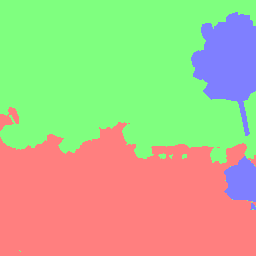

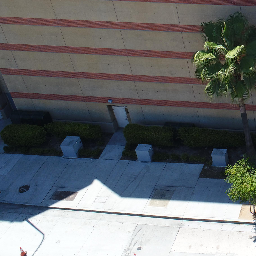

In [7]:
from PIL import Image
import numpy as np
import cv2

idx = 1
batch = dataset[idx]
print(batch.keys())

def write_images(path, image, n_row=1):
    image = ((image + 1) * 255 / 2).astype(np.uint8)
    if image.ndim == 3:
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGRA)
    cv2.imwrite('{}'.format(str(path)), np.squeeze(image))

def show_image(s, iftorch=False):
  if iftorch:
    s = s.detach().cpu().numpy()[0]
  s = ((s + 1) * 255 / 2).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)
    
segmentation = batch['segmentation']
show_image(segmentation)

image = batch['image']
show_image(image)
# write_images('test.png',image)
# write_images('test_seg.png',segmentation)


In [8]:
import torch.nn.functional as F

tensify = lambda x: torch.from_numpy(x[None]).to(device).permute(0,3,1,2).contiguous().float()
tensor_to_numpy = lambda x:x.detach().cpu().numpy()[0].transpose(1,2,0)


In [ ]:
# only works under conditional model
if not unconditional:
    seg_tensor = tensify(segmentation)
    c_code, c_indices = model.encode_to_c(seg_tensor)
    seg_rec = model.cond_stage_model.decode(c_code)
    seg_rec = F.softmax(seg_rec,dim=1)
    show_image(tensor_to_numpy(seg_rec), False)

[1, 256, 16, 16] [1, 256]
torch.Size([1, 256])
torch.Size([1, 3, 256, 256])


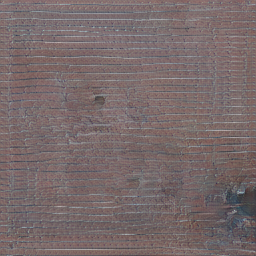

In [73]:
# sample random indices to image VQQGAN
nb = 1 #c_code.shape[0]
codebook_size = config.model.params.first_stage_config.params.embed_dim
# z_indices_shape = c_indices.shape
c_code_res = 16
res = 256
c_code_res = int(res**0.5)
z_indices_shape = [nb,res]
z_code_shape = [nb, codebook_size,c_code_res,c_code_res]
print(z_code_shape, z_indices_shape)
# z_code_shape = codebook_size
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
print(z_indices.shape)
x_sample = model.decode_to_img(z_indices, z_code_shape)
print(x_sample.shape)
show_image(tensor_to_numpy(x_sample), False)

In [56]:
# debug testing: replace random z indices with that of an encoded batch image
x = tensify(batch['image'])
c = x
quant_z, z_indices = model.encode_to_z(x)
quant_c, c_indices = model.encode_to_c(c)
gt_z_indices = z_indices

In [57]:
## transformer tech
from IPython.display import clear_output
import time
import os

output_dir = os.path.join("logs", "eval", "notebook_vis")
os.makedirs(output_dir, exist_ok=True)
idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

if not unconditional:
    cidx = c_indices
    cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 10


nx = z_code_shape[2]
ny = z_code_shape[3]

In [111]:
# generate a multiplied-scale scene with a large (partially fixed) random codebook
multiplier = 4
nnx = nx * multiplier
nny = ny * multiplier
c_code_res = 16
step_size = 8

target_image = np.zeros([multiplier*256, multiplier*256, 3])
z_indices = torch.randint(codebook_size, [nb,(multiplier**2)*res], device=model.device)
z_indices = z_indices.reshape(nb, nnx, nny)

# partially fill the z_indices with true data
z_indices[:,:nx, :ny] = gt_z_indices.reshape(nb, nx, ny)
occupancy = np.zeros(z_indices.shape).astype(bool)
occupancy[:,:nx, :ny] = True

start_t = time.time()
# outer loop: image to decode
for i in range(0, nnx - step_size, step_size):
    for j in range(0, nny - step_size, step_size):
        idx = z_indices[:, i:i+c_code_res, j:j+c_code_res].reshape(nb, -1)
        occ = occupancy[:, i:i+c_code_res, j:j+c_code_res].reshape(nb, -1)       
        # only update a block in idx if it is not occupied
        for ii in range(idx.shape[1]):
            if not occ[0,ii]:
                patch = torch.cat((c_indices, idx[:,:ii]),1)
                logits,_ = model.transformer(patch)
                logits = logits[:, -1, :]
                logits = logits/temperature
                if top_k is not None:
                  logits = model.top_k_logits(logits, top_k)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                idx[:,ii] = torch.multinomial(probs, num_samples=1)
                occ[:,ii] = True
        idx = idx.reshape(nb, c_code_res, c_code_res)
        occ = occ.reshape(nb, c_code_res, c_code_res)
        z_indices[:, i:i+c_code_res, j:j+c_code_res] = idx
        occupancy[:, i:i+c_code_res, j:j+c_code_res] = occ
        print(f"Time: {time.time() - start_t} seconds")
        print(f"Step: ({i},{j})")


Time: 0.0006451606750488281 seconds
Step: (0,0)
Time: 6.227718830108643 seconds
Step: (0,8)
Time: 12.497879981994629 seconds
Step: (0,16)
Time: 18.60176658630371 seconds
Step: (0,24)
Time: 24.697813034057617 seconds
Step: (0,32)
Time: 30.781784296035767 seconds
Step: (0,40)
Time: 36.884702920913696 seconds
Step: (0,48)
Time: 43.90026569366455 seconds
Step: (8,0)
Time: 47.39870810508728 seconds
Step: (8,8)
Time: 50.90134143829346 seconds
Step: (8,16)
Time: 54.40380358695984 seconds
Step: (8,24)
Time: 57.90440511703491 seconds
Step: (8,32)
Time: 61.40874481201172 seconds
Step: (8,40)
Time: 64.95981049537659 seconds
Step: (8,48)
Time: 71.96791672706604 seconds
Step: (16,0)
Time: 75.47381782531738 seconds
Step: (16,8)
Time: 78.98302292823792 seconds
Step: (16,16)
Time: 82.48594808578491 seconds
Step: (16,24)
Time: 86.0158383846283 seconds
Step: (16,32)
Time: 89.52677822113037 seconds
Step: (16,40)
Time: 93.03539037704468 seconds
Step: (16,48)
Time: 100.06185007095337 seconds
Step: (24,0)
T

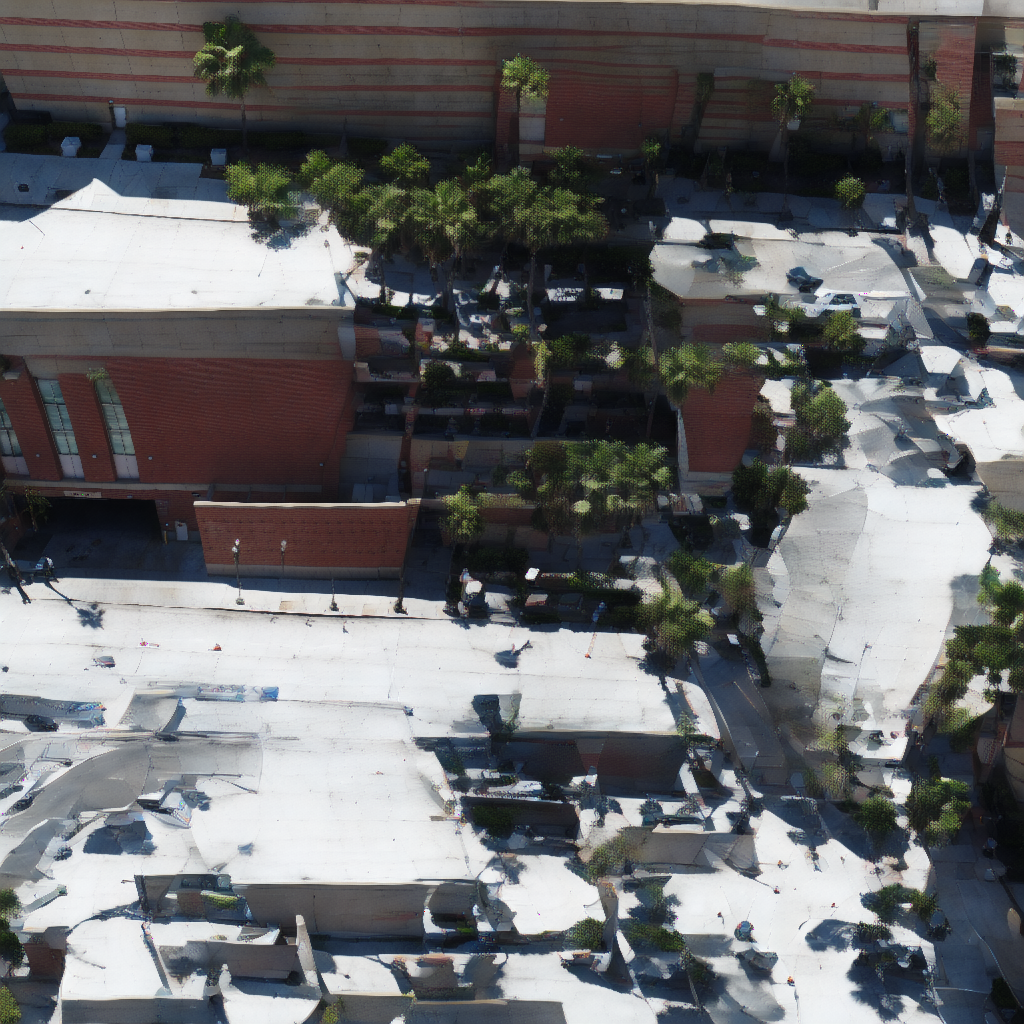

In [109]:
new_z_code_shape = [nb, 256, multiplier*16, multiplier*16]
x_sample = model.decode_to_img(z_indices, new_z_code_shape)
target_image = x_sample[0].detach().cpu().numpy().transpose(1,2,0)
# for i in range(0, nnx, c_code_res):
#     for j in range(0, nny, c_code_res):
#         patch_code = z_indices[:, i:i+c_code_res, j:j+c_code_res]
#         x_sample = model.decode_to_img(patch_code, z_code_shape)
#         patch_image = x_sample[0].detach().cpu().numpy().transpose(1,2,0)
#         target_image[i*16:i*16+256, j*16:j*16+256] = patch_image
show_image(target_image, False)

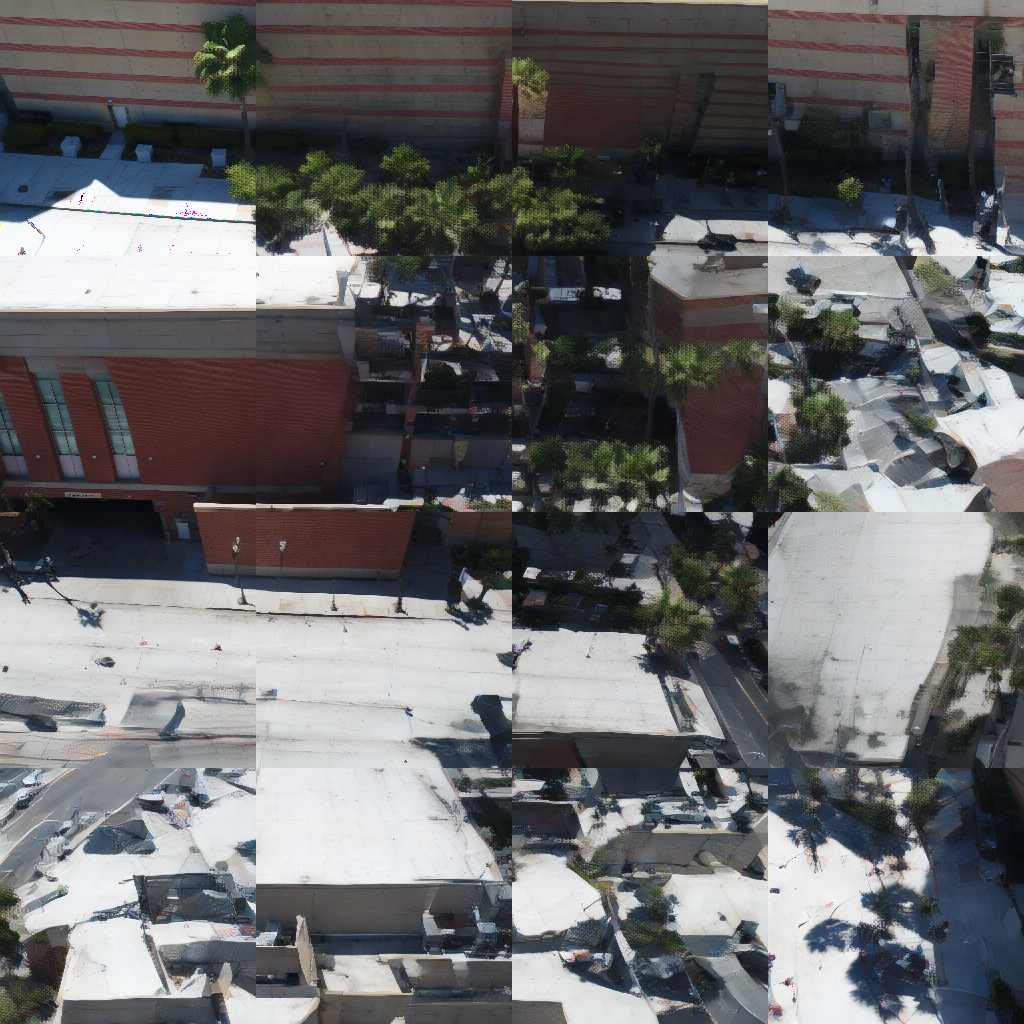

In [110]:
for i in range(0, nnx, c_code_res):
    for j in range(0, nny, c_code_res):
        patch_code = z_indices[:, i:i+c_code_res, j:j+c_code_res]
        x_sample = model.decode_to_img(patch_code, z_code_shape)
        patch_image = x_sample[0].detach().cpu().numpy().transpose(1,2,0)
        target_image[i*16:i*16+256, j*16:j*16+256] = patch_image
show_image(target_image, False)

In [33]:
# generate the original scene with a known encoded codebook
multiplier = 2
quant_z, z_indices = model.encode_to_z(x)
idx = z_indices
idx = idx.reshape(z_code_shape[0], z_code_shape[2],z_code_shape[3])

nx = z_code_shape[2]
ny = z_code_shape[3]
start_t = time.time()

for i in range(0, nx-0):
  if i <= 8:
    local_i = i
  elif nx-i < 8:
    local_i = 16-(nx-i)
  else:
    local_i = 8
  for j in range(0,ny-0):
    if j <= 8:
      local_j = j
    elif ny-j < 8:
      local_j = 16-(ny-j)
    else:
      local_j = 8
    
    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    # print(i_start, i_end, j_start, j_end)
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    if unconditional:
        patch = torch.cat((c_indices, patch), dim=1)
        logits,_ = model.transformer(patch[:,:-1])
    else:
        cpatch = cidx[:, i_start:i_end, j_start:j_end]
        cpatch = cpatch.reshape(cpatch.shape[0], -1)
        # patch = torch.cat((cpatch, patch), dim=1)
        logits,_ = model.transformer(patch[:,:-1], cpatch)

    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]
    logits = logits/temperature
    
    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      print(x_sample.shape)
      if not unconditional:
          show_image(tensor_to_numpy(seg_rec), False)
      # show_image(tensor_to_numpy(x_sample), False)
      write_images(os.path.join(output_dir, f"step{step}_{i}_{j}.png"), tensor_to_numpy(x_sample))
      patch_output = tensor_to_numpy(x_sample)
      import ipdb; ipdb.set_trace()

Time: 455.7585687637329 seconds
Step: (0,0) | Local: (0,0) | Crop: (0:16,0:16)
torch.Size([1, 3, 256, 256])
> /tmp/ipykernel_148134/4203767607.py(15)<cell line: 8>()
     14     local_i = 8
---> 15   for j in range(0,ny-0):
     16     if j <= 8:

ipdb> patch_output.shape
(256, 256, 3)
ipdb> exit()
